In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np

import pandas as pd 

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

# scipy for statistics and optimization
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# cvxpy
import cvxpy as cp

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix
from codelib.statistics import moments

from codelib.portfolio_optimization import risk_metrics as rm
from codelib.portfolio_optimization import risk_budget as rb
from codelib.portfolio_optimization import diversification as dm

# exponential probabilites
from codelib.statistics.historical_probabilities import calculate_exponential_decay_probabilities



from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

# Portfolio Heuristics and Risk based Strategies

Last week, we discussed some of the issues with classical Mean-Variance optimization. The main problem is that estimation uncertainty may result in far from optimal portfolios which can lead to bad out-of-sample properties. This notebook discuss some of the pragmatic alternatives based on heuristics such as the naive portfolio ($1 / N$) and the most diversified portfolio. 

## Risk based portfolios 

From last week, we know that an investor with quadratic utility

$$
U(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

the optimal portfolio for the simplest case with no constraint is given by

$$
\mathbf{w}^* = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} 
$$

The derivative of the optimal portfolio weights wrt. the expected return vector is given by 

$$
\frac{\partial \mathbf{w}^*}{\partial \boldsymbol{\mu}} = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1}
$$

This illustrates that the optimal portfolio is highly sensitive to the estimated expected returns which have led many academics and practioners to use purely risk based portfolios, relying on e.g. only the covariance matrix. 

### Minimum variance portfolios

As discussed in previous, the minimum variance portfolio is the solution to the below problem. 

$$
\mathbf{w}^* = \underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to relevant constraints, e.g. a budget constraint and a positivity constraints

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0 \; \text{ for } i=1,\dots, N
\end{align}
$$

__Example: Finding the minimum-variance portfolio using `CVXPY`__

In [2]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)

# number of assets
num_assets = len(mu)

In [3]:
"""
Solve for the minimum-variance weights 
"""
# optimization variable
w = cp.Variable(num_assets)

# define constraints 
constraints = [cp.sum(w)==1.0, w>=0]

# define problem 
prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

# solve problem 
prob.solve()

# print weights 
df_port_w = pd.DataFrame(data=w.value, index=['Asset 1', 'Asset 2', 'Asset 3'], columns=['$w_{min-var}$'], )
df_port_w

,$w_{min-var}$
Asset 1,4.792709e-22
Asset 2,1.951220e-01
Asset 3,8.048780e-01


### Risk budgetting portfolios 

We know that we can write the portfolio standard deviation as 

$$
\sigma_p(\mathbf{w}) = \mathbf{w}^\top \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \text{MR}_i = \sum_{i=1}^N \text{RC}_i
$$

where $\text{MR}_i = \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}$ is the marginal risk of asset $i$ and $\text{RC}_i$ is the risk contribution of asset $i$. 

There is a large literature on *risk parity investing* where the focus is on allocating risk instead of capital, e.g. we want an equal amount of risk coming from bonds and stocks. The problem that we want to solve is

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = b_i  \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

where $b_i$ is the risk coming from the $i$'th asset. In addition, we would likely impose positivity contraints $b_i \geq 0, w_i \geq 0$, weights summing to one $\sum_{i=1}^N w_i = 1$, and $\sum_{i=1}^N b_i = 1$. 

We have previously seen how we can solve this problem in the two asset case - now we will look at the more general case! 

### Solving for the risk budgetting weights 

Since we know that 

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = b_i 
$$

We could find the risk budgetting portfolio as 

$$
\mathbf{w}^* = \arg \min \sum_{i=1}^N \left(w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} - b_i \right)^2
$$

subject to

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0 \; \text{ for } i=1,\dots, N
\end{align}
$$

__Example: Find the risk budget portfolio__

We continue with the same assumptions as in the previous example. We seek to find the equal risk contribution weights. 

In [4]:
def risk_budget_objective(weights: np.ndarray,
                          cov_mat: np.ndarray,
                          b: Union[float, np.ndarray] = None): 
    
    if b is None: 
        b = 1.0 / len(weights)
    
    rc = rb.calculate_risk_contributions_std(weights, cov_mat, scale=True)
    
    return np.sum(np.square(rc - b)) * 100 * 100

In [5]:
init_w  = np.ones(num_assets) / num_assets

budget_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

res_rb = optimize.minimize(risk_budget_objective, x0=init_w, args=(cov_mat,),
                           constraints=(budget_constraint),
                           bounds=[(0.0, 1.0)] * num_assets)

df_port_w['$w_{rb}$'] = res_rb.x

In [6]:
df_port_w

,$w_{min-var}$,$w_{rb}$
Asset 1,4.792709e-22,0.202225
Asset 2,1.951220e-01,0.307039
Asset 3,8.048780e-01,0.490736


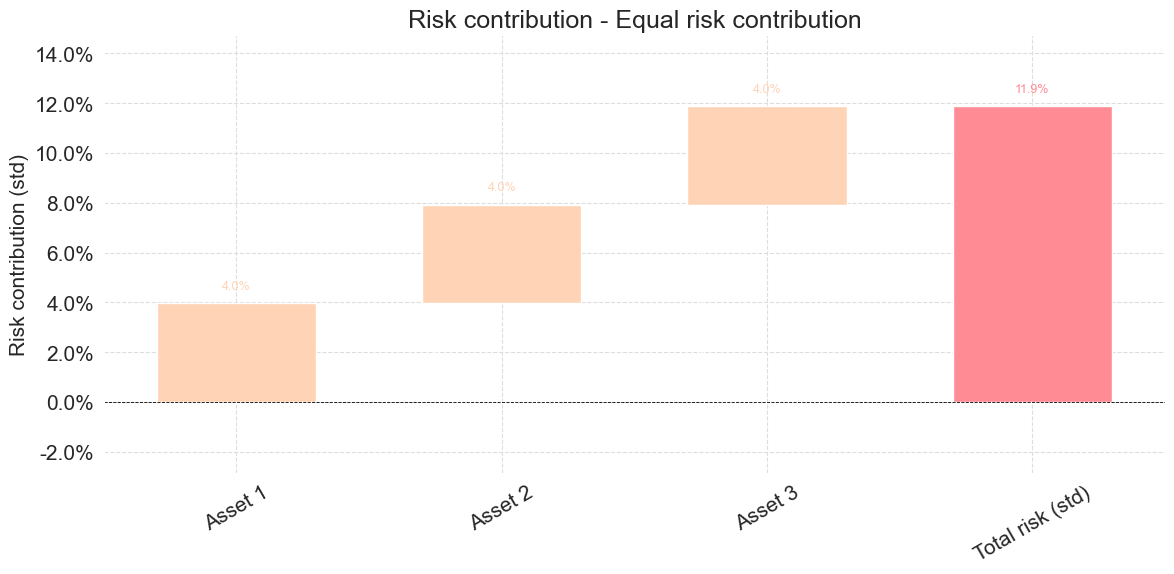

In [7]:
risk_contrib = rb.calculate_risk_contributions_std(df_port_w['$w_{rb}$'], cov_mat)

fig, ax = waterfall_chart(values=risk_contrib*100,
                          labels=df_port_w.index,
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution (std)", title="Risk contribution - Equal risk contribution")

fig.set_size_inches(12, 6);
plt.tight_layout()

plt.savefig("equal_risk_contribution_3_assets.png", dpi=300)

In [8]:
df_port_w

,$w_{min-var}$,$w_{rb}$
Asset 1,4.792709e-22,0.202225
Asset 2,1.951220e-01,0.307039
Asset 3,8.048780e-01,0.490736


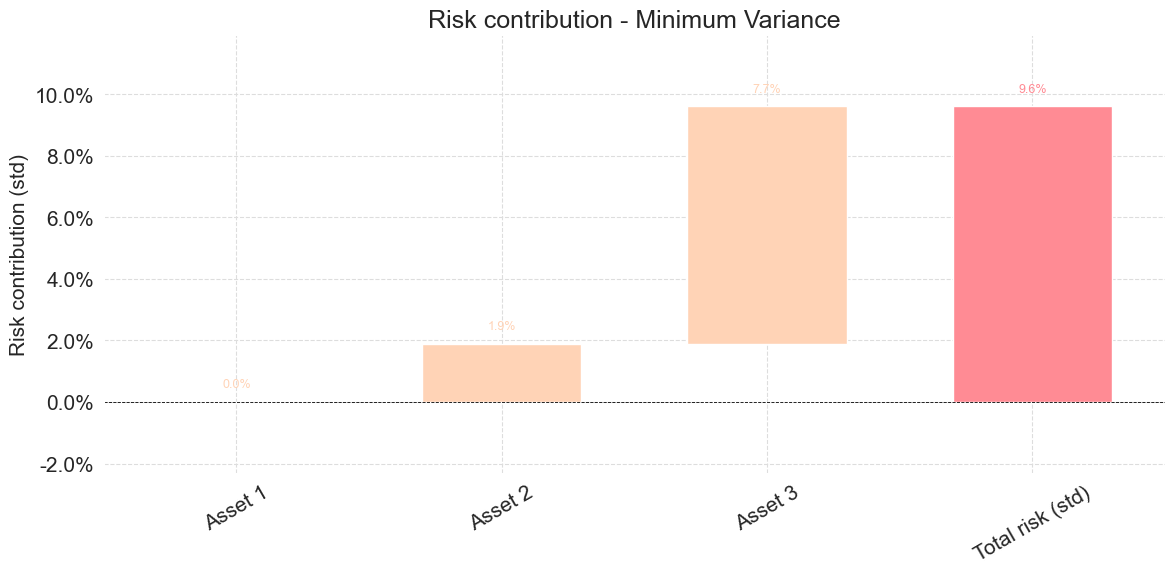

In [9]:
risk_contrib = rb.calculate_risk_contributions_std(df_port_w['$w_{min-var}$'], cov_mat)

fig, ax = waterfall_chart(values=risk_contrib*100,
                          labels=df_port_w.index,
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution (std)", title="Risk contribution - Minimum Variance")

fig.set_size_inches(12, 6);

plt.tight_layout()
plt.savefig("min_var_risk_contribution_3_assets.png", dpi=300)

### Risk budgetting portfolios as a convex optimization problem

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778) suggest an alternative optimization problem that also gives the risk budgetting portfolio

$$
\mathbf{x}^* = \arg \min \mathbf{x}^\top \boldsymbol{\Sigma} \mathbf{x}
$$

subject to

$$
\begin{align}
\mathbf{b}^\top \ln \mathbf{x} &\geq c \\
\mathbf{x} &\geq \mathbf{0}
\end{align}
$$

Finally, define 

$$
\mathbf{w}^* = \frac{\mathbf{x}^*}{\mathbf{1}^\top \mathbf{x}^*}
$$

such that the portfolio weights sum to one. 

In [10]:
w = cp.Variable(num_assets)

b = 1.0 / num_assets
c = 0.1

constraints = [w >= 0.0001,
               cp.sum(b * cp.log(w)) >= c]

prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(w, cov_mat)), constraints=constraints)

prob.solve()

w.value / w.value.sum()

array([0.20225192, 0.30704504, 0.49070303])

### Naive Risk Parity

In the naive risk parity portfolio the allocation to a specific asset is based on the inverse volatility portfolio

$$
\mathbf{w}_{\text{IV}} = \left[\frac{1 / \sigma_1}{\sum_{i=1}^N 1 / \sigma_i}, ..., \frac{1 / \sigma_N}{\sum_{i=1}^N 1 / \sigma_i} \right]^\top
$$

In [11]:
def calculate_naive_risk_parity(vols: np.ndarray) -> np.ndarray:
    
    """
    Calculate the inverse volatility weights 
    
    Parameters
    ----------
    vols: 
        Volatilites. 
    
    Returns
    -------
    np.ndarray
        Portfolio weights. 
    
    
    """
    
    inv_vols = 1.0 / vols
    sum_inv_vols = np.sum(inv_vols)
    
    w_iv = inv_vols / sum_inv_vols
    
    return w_iv

In [12]:
df_port_w['$w_{inv-vol}$'] = calculate_naive_risk_parity(vols)

In [13]:
df_port_w.style.format("{:.2%}")

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$
Asset 1,0.00%,20.22%,23.08%
Asset 2,19.51%,30.70%,30.77%
Asset 3,80.49%,49.07%,46.15%


### A simulation study comparing the risk-based strategies





In [14]:
"""
Define functions to calculate optimal portfolios
"""
    
    
def calculate_risk_parity(cov_mat: np.ndarray) -> np.ndarray:  
    
    num_assets = cov_mat.shape[0]
    
    w = cp.Variable(num_assets)

    b = 1.0 / num_assets
    c = 0.1

    constraints = [w >= 0.0001,
                   cp.sum(b * cp.log(w)) >= c]

    prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(w, cov_mat)), constraints=constraints)

    prob.solve()

    return w.value / w.value.sum()
    
    
def calculate_minimum_variance(cov_mat: np.ndarray) -> np.ndarray: 
    
    num_assets = cov_mat.shape[0]
    
    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints 
    constraints = [cp.sum(w)==1.0, w>=0]

    # define problem 
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    # solve problem 
    prob.solve()
    if prob.status == 'optimal': 
        return w.value
    else: 
        prob.solve(solver="SCS")
        return w.value

In [15]:
"""
Generate data 
"""

T = 60

corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / np.sqrt(12) / 100.0
mu = np.array([3.2, 3.12, 8.0, 8.2]) / 12.0 / 100.0
#mu_2 = np.array([3.2, 3.22, 8.4, 8.2]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat, vols)

num_sim = 10_000

sim_cov_mat = stats.wishart.rvs(df = T-1, scale = cov_mat / T, size=num_sim) 
#sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

In [16]:
"""
Calculate true optimal allocations
"""

true_rp_port = calculate_risk_parity(cov_mat)
true_naive_rp_port = calculate_naive_risk_parity(np.diag(cov_mat))
true_min_var_port = calculate_minimum_variance(cov_mat)

In [17]:
"""
Find optimal portfolios 
"""

rp_ports = np.array([calculate_risk_parity(sim_cov_mat[i])
                     for i in range(num_sim)])
naive_rp_ports = np.array([calculate_naive_risk_parity(np.diag(sim_cov_mat[i]))
                           for i in range(num_sim)])
min_var_ports = np.array([calculate_minimum_variance(sim_cov_mat[i])
                          for i in range(num_sim)])

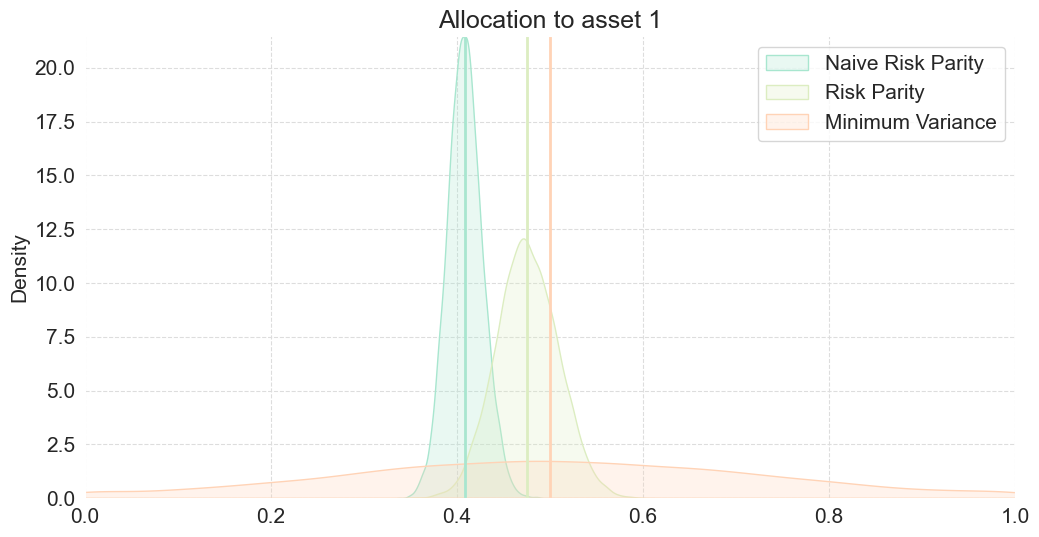

In [18]:
idx=0

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_ports[:, idx], fill=True, ax=ax, label="Naive Risk Parity")
ax.axvline(true_rp_port[idx],color=default_colors['green'])
sns.kdeplot(naive_rp_ports[:, idx], fill=True, ax=ax, label="Risk Parity")
ax.axvline(true_naive_rp_port[idx],color=default_colors['light_green'])
sns.kdeplot(min_var_ports[:, idx], fill=True, ax=ax, label="Minimum Variance")
ax.axvline(true_min_var_port[idx],color=default_colors['orange'])
ax.set_xlim([0.0, 1.0])
ax.set_title("Allocation to asset {}".format(idx + 1))
ax.legend();

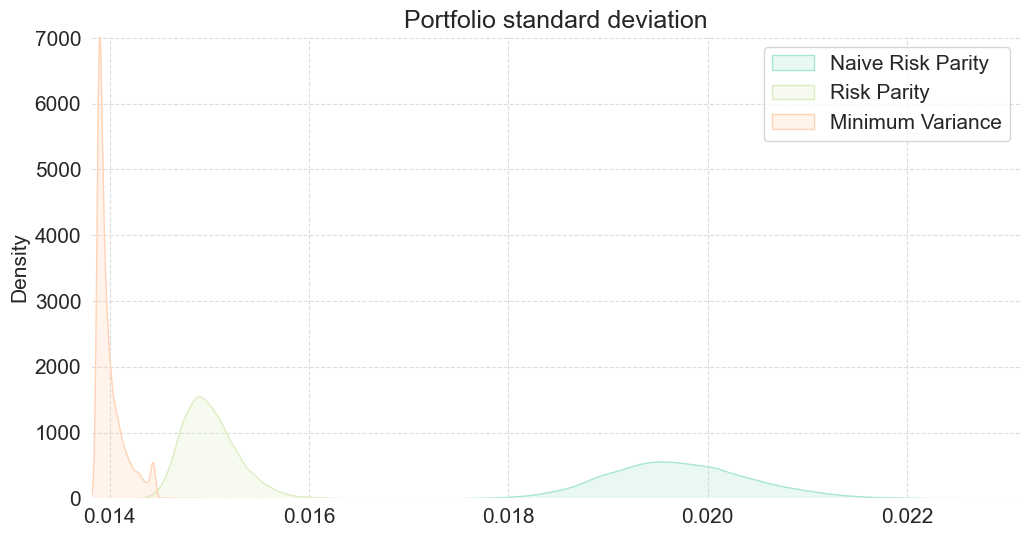

In [19]:
"""
Evaluate portfolio std.
"""
rp_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1,
                                  rp_ports, (cov_mat))
naive_rp_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, naive_rp_ports, (cov_mat))
min_var_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, min_var_ports, (cov_mat))


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_std, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_std, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_std, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio standard deviation")
ax.legend();

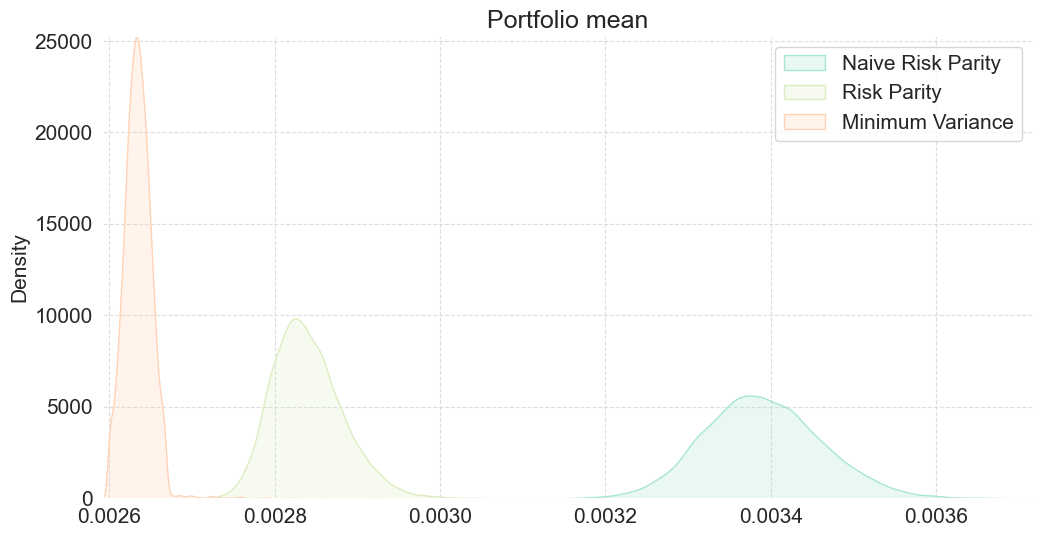

In [20]:
"""
Evaluate portfolio mean
"""
rp_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, rp_ports, (mu))
naive_rp_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, naive_rp_ports, (mu))
min_var_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, min_var_ports, (mu))


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_mu, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_mu, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_mu, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio mean")
ax.legend();

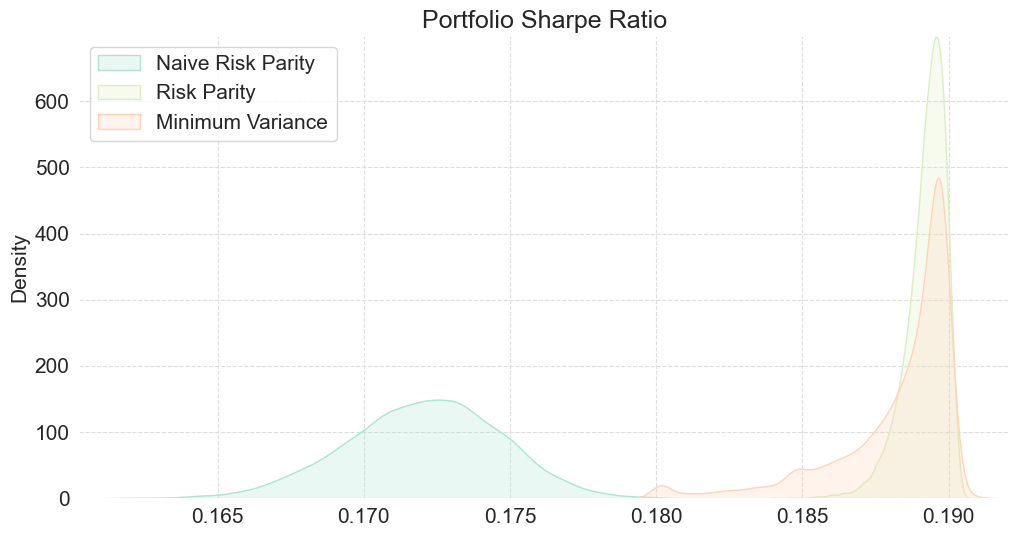

In [21]:
"""
Evaluate Sharp - zero risk free
"""
rp_port_sr = rp_port_mu / rp_port_std
naive_rp_port_sr = naive_rp_port_mu / naive_rp_port_std
min_var_port_sr = min_var_port_mu / min_var_port_std


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_sr, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_sr, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_sr, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio Sharpe Ratio")
ax.legend();

## Most Diversified Portfolio 

Another approach is to focus directly on diversification. [Choueifaty and Caignard (2008), "Toward Maximum Diversification"](https://www.tobam.fr/wp-content/uploads/2014/12/TOBAM-JoPM-Maximum-Div-2008.pdf) defines the diversification ratio

$$
\text{CC}(\mathbf{w}, \boldsymbol{\Sigma}) = \frac{\mathbf{w}^\top \mathbf{v}}{ \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma}\mathbf{w}}} = \frac{\sum_{i=1}^N w_i \sigma_i}{\sqrt{ \mathbf{w}^\top \boldsymbol{\Sigma}\mathbf{w}}}
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix and $\mathbf{v}$ is the vector of volatilities. The maximum diversification portfolio can be obtained as 

\begin{align*}
	\max_{\mathbf{w}}  \quad & \text{CC}(\mathbf{w}, \boldsymbol{\Sigma}) \\
	\textrm{s.t.} \quad & \mathbf{w}^\top \mathbf{1} = 1 \\
	 & w_i \geq 0, \; i=1,...,N
\end{align*}

__Example: Implementing the most diversified portfolio__

In [22]:
def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    """
    Calculates the diversification ratio of Chouefaty and Coignard (2008)

    .. math::

        \\begin{equation}
            \\text{GLR}(w, \\Sigma) = \\frac{\\sum_{i=1}^N w_i \\sigma_i}{\\sqrt{w^{\\top} \\Sigma w}}
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    cov_mat:
        Covariance matrix.
        
    Returns
    -------
    float
        Diversification ratio.
    """

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [23]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)

# number of assets
num_assets = len(mu)

In [24]:
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat) * 100 * 100, init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [25]:
df_port_w['$w_{cc}$'] = calculate_most_diversified_portfolio(cov_mat)
df_port_w.style.format("{:.2%}")

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$,$w_{cc}$
Asset 1,0.00%,20.22%,23.08%,0.00%
Asset 2,19.51%,30.70%,30.77%,40.00%
Asset 3,80.49%,49.07%,46.15%,60.00%


In [26]:
"""
Correlation between assets and CC-portfolio
"""

w_cc = df_port_w['$w_{cc}$'].values
idx = 2
pick_vec = np.zeros(num_assets)
pick_vec[idx] = 1.0

w_cc @ cov_mat @ pick_vec / (rm.calculate_portfolio_std(w_cc, cov_mat) * vols[idx])

np.float64(0.8366600018112539)

## Norm and diversification constraints

[Victor DeMiguel, Lorenzo Garlappi, Francisco J. Nogales and Raman Uppal (2009), "A Generalized Approach to Portfolio Optimization: Improving Performance by Constraining Portfolio Norms"](https://www.jstor.org/stable/40539189) discuss different norm constraints in the context of the minimum-variance portfolio. One example is the use of a 2-norm constraint: 

\begin{align*}
	\min_{\mathbf{w}}  \quad & \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}\\
	\textrm{s.t.} \quad & \mathbf{w}^\top \mathbf{1} = 1 \\
	 & w_i \geq 0, \; i=1,...,N \\
     & \Vert \mathbf{w} \Vert_2 \leq \delta
\end{align*}

Note that 

$$
\Vert \mathbf{w} \Vert_2 = \sum_{i=1}^N w_i^2 
$$

Thus, if $\delta = 1/N$ then we will end up with the naive, equally weighted portfolio. We can therefore think of this constraints as a restriction of how far we can deviate from the $1/N$ portfolio. 

In [27]:
def calculate_minimum_variance_norm(cov_mat: np.ndarray, delta: float) -> np.ndarray: 
    
    num_assets = cov_mat.shape[0]
    
    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints 
    constraints = [cp.sum(w)==1.0, w>=0,
                   cp.quad_form(w, np.eye(num_assets)) <= delta]

    # define problem 
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)
    
    # solve problem 
    try:  
        prob.solve()
    except: 
        prob.solve(solver="SCS")
    
    return w.value

In [28]:
df_port_w['$w_{min-var, L2}$'] = calculate_minimum_variance_norm(cov_mat, delta=1/3) # 1/31/3 + 0.0000001
df_port_w.style.format("{:.2%}")

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$,$w_{cc}$,"$w_{min-var, L2}$"
Asset 1,0.00%,20.22%,23.08%,0.00%,33.33%
Asset 2,19.51%,30.70%,30.77%,40.00%,33.33%
Asset 3,80.49%,49.07%,46.15%,60.00%,33.33%
